<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Heat transport

In this project we will discretize and timestep two systems that describe heat transport. In the first part we will timestep a box model for the Earth's surface temperature with heat buffering provided by the deep ocean. In the second part, we will timestep the one-dimensional diffusion equation which can be used to describe heat moving through a medium (e.g. the ground or still air and water).

Through this project, we will learn how to efficiently timestep ordinary and partial differential equations and examine errors introduced by the numerical discretization. We will also have the chance to explore the timescales and physical processes involved in heat transport in the climate system.

## 1. Climate box model

In this part of the project we will timestep the following box model.

$$ C_s \partial_t T = F(t) - \gamma(T-\theta) $$

$$ C_d \partial_t \theta = \gamma (T-\theta) $$

Here, $T(t)$ represents the global mean surface temperature as a function of time and $\theta(t)$ is the temperature of the deep ocean, both expressed as the difference between the temperature and a pre-industrial equilibrium in units of $^\circ K$. The net surface heat flux, $F(t)$, drives departures from the pre-industrial temperatures. The heat flux between the surface and deep ocean is assumed to be proportional to the difference between the surface and deep ocean temperatures. The constants are the heat capacity of the surface of the Earth, $C_s$, the heat capacity of the deep ocean, $C_d$, and the heat flux coefficient, $\gamma$, all given in units of $W/^\circ K/m^2$. Note that $C_s$ and $C_d$ (as defined in Nicklas et al. 2025) are heat capacities per year; i.e. $1/C_s$ tells us how much the surface temperature would increase if a flux of 1 $W/m^2$ were applied for one year.

This model is inspired by a more complicated version of a two box climate model in the paper referenced below. (Interested students might consider adding some additional features from their model, but this is not required for this project).

*Nicklas, J.M., Fox-Kemper, B. and Lawrence, C., 2025. Efficient Estimation of Climate State and Its Uncertainty Using Kalman Filtering with Application to Policy Thresholds and Volcanism. Journal of Climate, 38(5), pp.1235-1270.*

Below, we start to build code to solve these equations. Execute the code cells below.  In some cases you will be asked to add code.

Student tasks are in [Section 1.1](#section1pt1), [Section 1.2](#section1pt2), and [Section 1.3](#section1pt3).

In [20]:
# Before we start, import necessary libraries. Run this cell first.
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

Now, let's define values for the various constants. These values are taken from Nicklas et al., 2025.

In [21]:
C_s = 17 # heat capacity of the Earth's surface (W/m^2/K)
C_d = 156 # heat capacity of the deep ocean (W/m^2/K)

gamma = 0.67 # heat exchange coefficient between surface and deep ocean (W/m^2/K)
             # i.e. ~0.67 W/m² of heat is exchanged per 1 K of T−θ difference.

Now, let's define a function for F(t), the net surface heat flux (in units of $W/m^2$) that will force our model. This function is here to represent the heat imbalance caused by antropogenic greenhouse gases in the atmosphere. When $F=0$, there is no net surface heat flux. The argument, $t$, is the time in years. We will let $t=0$ denote the start of our additional warming, and we set $F=1$ if $t<200$ years and $F=0$ if $t>200$ years. This corresponds to a very bad-case emissions scenario with an abrupt drop in emissions after 200 years.

In [22]:
# F = 1 before year 200, then F = 0 after
def F(t):
    return 1 if t < 200 else 0

Next, set the initial conditions. We will use arrays `T` and `theta`. `T[i]` represents the ith value in the array. We will use `T[0]` and `theta[0]` to hold the initial conditions. Subsequent values, `T[2]`, `T[3]`, etc. will be determined by timestepping the equations. We start by initializing the arrays using numpy and filling them with zeros and then set the initial values (this isn't necessary here since our values are zero anyway, but the code is here so that you can change the initial conditions easily)

In [23]:
Nt = 500 # number of time steps (including the starting point)
T = np.zeros(Nt) # surface temperature array
theta = np.zeros(Nt) # deep ocean temperature array
T[0] = 0 # initial surface temperature anomaly (ºK)
theta[0] = 0 # initial deep ocean temperature anomaly (ºK)

Now, create an array with the time (in years) corresponding to each time index. Also, calculate the timestep, `dt`.

In [24]:
t = np.linspace(0, 500, Nt) # time in years - this starts at 0 and ends at 500, with Nt total points
dt = t[1] - t[0] # timestep in years

Finally, we are ready to create a for loop to timestep the equations listed at the top of the section.

### 1.1 Student task:
<a id='section1pt1'></a>
Fill in the interior of the for loop to timestep the equations from the start of Section 1 using the Explicit Euler method.

In [25]:
for i in range(0, Nt-1):                                                # loop over all time steps
    T[i+1] = T[i]+ dt*((F(t[i])- gamma*(T[i]-theta[i]))/C_s)            # find surface temperature (forcing minus heat loss to deep /C_s)
    theta[i+1] = theta[i] + dt * ( (gamma * (T[i] - theta[i])) / C_d )  # find deep ocean temperature (heat gained from surface/ C_d)

After you are finished, run the cell below to plot the results

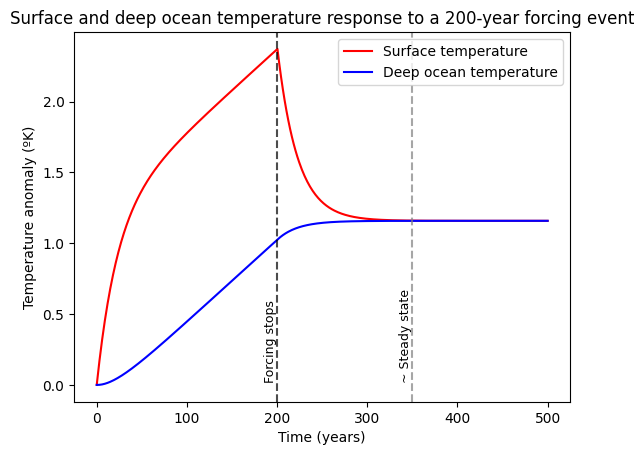

In [ ]:
# plotting the results
plt.plot(t,T,'r-')
plt.plot(t,theta,'b-')

# 'Forcing stops' vertical line
plt.axvline(x=200, color='k', linestyle='--', alpha=0.7)
y_offset = 0.05 * (plt.ylim()[1] - plt.ylim()[0])
plt.text(200, plt.ylim()[0] + y_offset, 'Forcing stops',
         rotation=90, va='bottom', ha='right', fontsize=9)

# '~ Steady state' vertical line
plt.axvline(x=350, color='grey', linestyle='--', alpha=0.7)
plt.text(350, plt.ylim()[0] + y_offset, '~ Steady state',
         rotation=90, va='bottom', ha='right', fontsize=9)

plt.title('Surface and deep ocean temperature response to a 200-year forcing event')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.show()

### 1.2 Student task
<a id='section1pt2'></a>
Discuss the rates of change the temperature of the Earth's surface and the deep ocean at the start of the model run.  Can you explain the response of $T$ and $\theta$ to the forcing by defining characteristic timescales from the box model equations?

**1.2 DISCUSSION:**

The rate of temperature change of the Earth's surface is far greater than that of the deep ocean during the 200 years of forcing. The governing model equations tell us that energy added to the system directly enters the Earth's surface before being transfered to the deep ocean. These equatiosn also tell us the the surface layer has a small heat capacity, responsing on a timescale of ~25 years, whereas the deep ocean has a far greater heat capactity and responds on a timescale of ~233 years. This heat capacity difference explains why the two systems have such different response times.

Earth's surface has a much smaller heat capacity than the deep ocean so it's uptake of energy is fast which drives a steep increase in temperature. Meanwhile, the deep ocean has a far greater heat capacity so lags behind the Earth's surface and warms more slowly.

When external forcing stops at 200 years the surface instanly responds with a decrease in temperature as there is no energy entering the system and heat is being transfered into the deep ocean. Thus, the temperature of the deep ocean continues slowly increasing until both the surface and deep ocean ready a new steady state at aproximately 1.16K above the original 0K temeperature anomaly. This shows how energy is conserved in the system - external forcing of additional energy pushed the sytem into a new stable state.

*  downward heat flux, gamma = (T - theta) strengthens over time as the surface warms.

characteristic timescales:

This climate model contains two characteristic timescales that govers its response. the first timescale arises from the temperature difference between the surface and deep ocean boxes which decays exponentially as the two boxes equilibriate. Setting the external forcing F(t) = 0 we can see that with the parameters used this timescale is approximately 23 years. The second timescale is infinite in the basic version of the model, corresponding to the conservation of total energy once forcing stops.


### 1.3 Student task
<a id='section1pt3'></a>
Modify the forcing function, `F(t)` above with 2-3 scenarios of your choice. Plot the temperature response for each scenario and briefly (2-3 sentences each) describe the temperature responses in each scenario. You will need to replicate some of the code blocks above so that you can produce a new set of plots below.

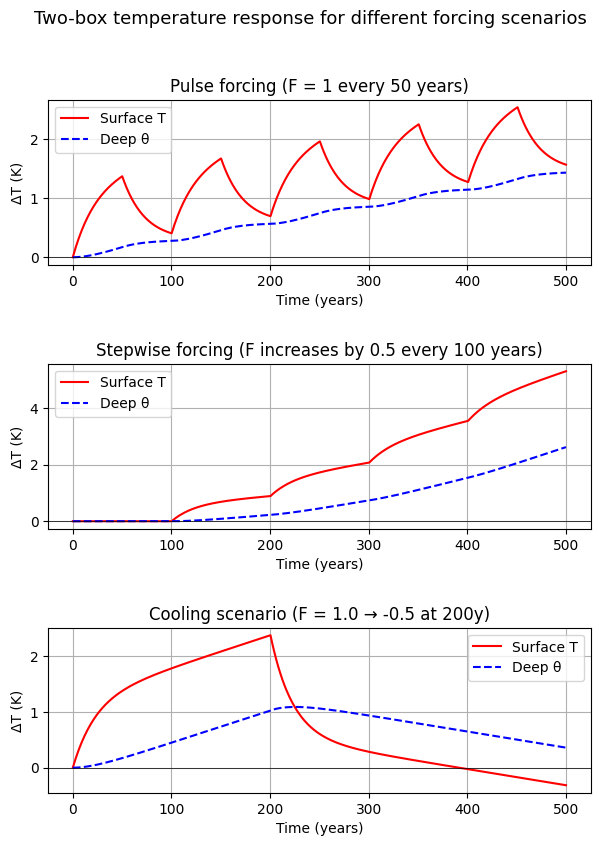

In [26]:
# Parameters
C_s = 17
C_d = 156
gamma = 0.67
Nt = 500
t = np.linspace(0, 500, Nt)
dt = t[1] - t[0]


# 1. Pulse forcing: F = 1 for 50 years, F = 0 for 50 years - repeat until year 500
def F_pulse(t):
    cycle = t % 100
    return 1.0 if cycle < 50 else 0.0

# 2. Stepwise forcing: F increases by 0.5 every 100 years
def F_stepwise(t):
    step = int(t // 100)
    return 0.5 * step

# 3. Cooling scenario: F = 1 for 0–200 years, then -0.5 afterwards
def F_cooling(t):
    return 1.0 if t < 200 else -0.5


# Integrator function (to solve the model over time using Explicit Euler)
def integrate_box(Ffun, t, dt, C_s, C_d, gamma, T0=0.0, theta0=0.0):
    Nt = len(t)                              # number of time steps
    T = np.zeros(Nt)                         # surface temperature array
    theta = np.zeros(Nt)                     # deep ocean temperature array
    T[0] = T0                                # initial surface temperature
    theta[0] = theta0                        # initial deep temperature

    for i in range(Nt - 1):                  # loop through all time steps
        exch = gamma * (T[i] - theta[i])     # heat exchange between layers
        T[i+1] = T[i] + dt * ((Ffun(t[i]) - exch) / C_s)    # update surface
        theta[i+1] = theta[i] + dt * (exch / C_d)           # update deep

    return T, theta                          # return temperature time series


# Scenario list
scenarios = [
    ("Pulse forcing (F = 1 every 50 years)", F_pulse),
    ("Stepwise forcing (F increases by 0.5 every 100 years)", F_stepwise),
    ("Cooling scenario (F = 1.0 → -0.5 at 200y)", F_cooling),
]


# Plotting
fig, axes = plt.subplots(len(scenarios), 1, figsize=(7, 9))

for ax, (label, Ffun) in zip(axes, scenarios):
    T_s, th_s = integrate_box(Ffun, t, dt, C_s, C_d, gamma)
    ax.plot(t, T_s, 'r-', label='Surface T')
    ax.plot(t, th_s, 'b--', label='Deep θ')
    ax.axhline(0, color='k', linewidth=0.5)  # optional: zero line
    ax.set_ylabel('ΔT (K)')
    ax.set_xlabel('Time (years)')
    ax.set_title(label)
    ax.grid(True)
    ax.legend()

fig.suptitle("Two-box temperature response for different forcing scenarios", fontsize=13)
fig.subplots_adjust(hspace=0.6)
plt.show()


**1.3 DISCUSSION:**

**1. Pulse Forcing (50-year cycles)**

Like in the 200yr forcing senario, the surface temperature responds quickly to each 50-year forcing phase while the deep ocean temperature rise lags behind. When forcing is 'switched off' every 50 years the surface responds by losing heat as its transfered to the deep ocean and in doing so shows oscillations in the plot. In doing so, the deep ocean shows a continous upwards temperature change trend across the 500 years of ON/OFF forcing. This happens because the deep ocean integrates the repeated pulses and stores the heat over time even when surface forcing is temporarily zero. Over successive pulses, baseline temperature of the entire model rises although the sytem never has enough time to reach a steady state before the next forcing event.


**2. Stepwise Forcing (every 100 years)**
The step forcing scenario shows how much quicker the surface responds to forcing compared to the deep ocea. Each step increase causes a fast step response in surface tempersature whereas the deep ocean lags significantly and warms in a more smooth manner as it integrates the forcing over time. As the model scenario progresses the temperature difference between the surface and deep ocean widens with each forcing step showing how surface warming leads ocean warming. This occurs because the steps occur faster than the deep ocean can fully equilibrate, the gap between surface and deep temperature widens progressively. This scenario shows how step forcing has a cumulative effect on both layers and how the system does'nt return to a steady state bewteen steps leading to a steadily rising temperature trend.


**3. Cooling Scenario (1.0 → -0.5 at 200 years)**

The cooling scenario really highlights the different heat capacity of the two boxes. for the first 200 years temperature change in each box is just as we'd expectwith the surface warming more rapidly and the ocean laging behind. However, when foring becomes negative at the year 200 the system loses heat from the surface box. This causes the surface to cool very quickly. However, the deep ocean cools more gradually and retains alot more heat than the surface years after the forcing turns negative. This is becasue the ocean has a large eat capacity and releases stored heat over a much longer response timescale. If the negative forcing stopped the boxes would eventially find a new steady state at a temperature below the inition 0K temperature anomaly.

## 2. Diffusion equation

In this part of the project we will solve the 1-D diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

We will use second order finite differences to approximate the $x$-derivatives, and we will implement and compare two timestepping methods.

Student tasks are in [Section 2.1](#section2pt1), [Section 2.2](#section2pt2), and [Section 2.3](#section2pt3).

First, let's discretize the second order derivative using finite differences. The function below builds a coefficient matrix, $M$, so that $Mc$ is a discretized version of $\partial^2_x c$, where in our discretized version $c$ is a column vector.

In [27]:
  def construct_M_with_BC(x):
  # this function builds the discrete spatial operator for the diffusion equation
  # builds a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
        dx = x[1] - x[0]  # infer the uniform grid spacing
        M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2 # approximates c''(x) using second-order central differences
        M = sp.csr_matrix(M) # turn M into a sparse matrix to save memory and improve speed
        return M

Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [28]:
def EE(x, t, kappa):
# this function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # start timer to report how long the integration takes

    # infers the (uniform) timestep from the time grid
    dt = t[1] - t[0]

    # constructs the finite-difference matrix for the second spatial derivative
    M = construct_M_with_BC(x)

    # set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # print the elapsed time

    print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [29]:
def CN(x, t, kappa):
# this function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the Crank–Nicolson semi-implicit and second order finite difference methods
    start_time = time.time()  # start a timer

    # infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M_with_BC(x)  # construct the coefficient matrix for the second derivative

    # set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # this matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # calculate the inverse of A (this only needs to be done once)

    # create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # print the elapsed time

    print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [30]:
def set_ics(x, kappa, t_ic):
  #this function sets the initial condition by evaluating the exact solution at time t_start
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [31]:
# defining parameters
kappa = 0.001  # diffusivity (original kappa = 0.001)

# timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # create a vector of times
x = np.linspace(x_start, x_end, Nx)  # create a vector for x

Run each method once:

In [32]:
# run the simulations
c_EE = EE(x, t, kappa) # Explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

Explicit Euler method took 0.05 seconds
Crank-Nicolson method took 0.06 seconds


and finally, plot the results side-by-side

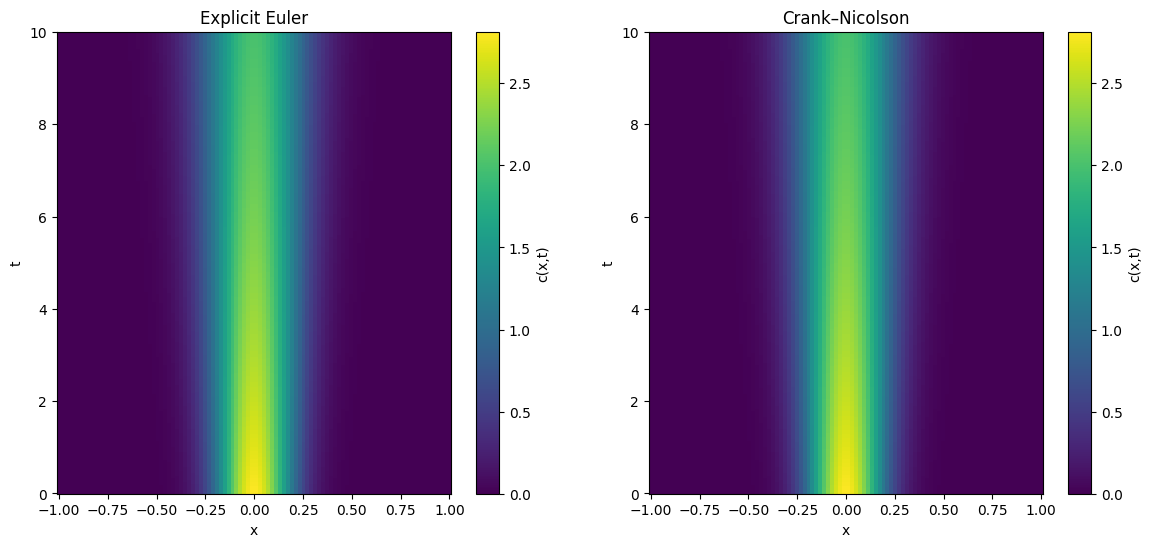

In [33]:
# plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
pcm1 = plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')
plt.colorbar(pcm1, label='c(x,t)')

plt.subplot(1, 2, 2)
pcm2 = plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank–Nicolson')
plt.colorbar(pcm2, label='c(x,t)')

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have different stability properties. To explore this, try increasing the diffusivity, $\kappa$, and see how each method responds. Discuss your findings below (~2-3 sentences).

**2.1 Discussion**

When increasing the diffusivity of 0.001 in small increments the Explicit Euler method approached its stability limit at k = 0.02 and completely became unstable at k > 0.025. The Crank-Nicolson method proved stable for all tested values of k.

This stability difference between the methods arises from their amplification factors. In the Explicit Euler method the amplification factor exceeds 1 when κ > 0.025 causing errors to grow and the method to become unstable. As κ increases, the maximum stable time step becomes smaller so a fixed Δt eventurally surpasses the stability limit. The Crank-Nicolson method is unconditionally stable because its amplification factor remains bounded by 1 for any Δt or κ.

The Explicit Euler method remains stable only if the time steps are small enough. The Crank-Nicolson method remains stable for any time step and is often the prefered method for diffusion problems where long timescales are involved. It is important to note that CN still needs a reasonablt time step for good accuracy.


### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

Explicit Euler took 0.02 s
Crank-Nicolson method took 0.09 seconds


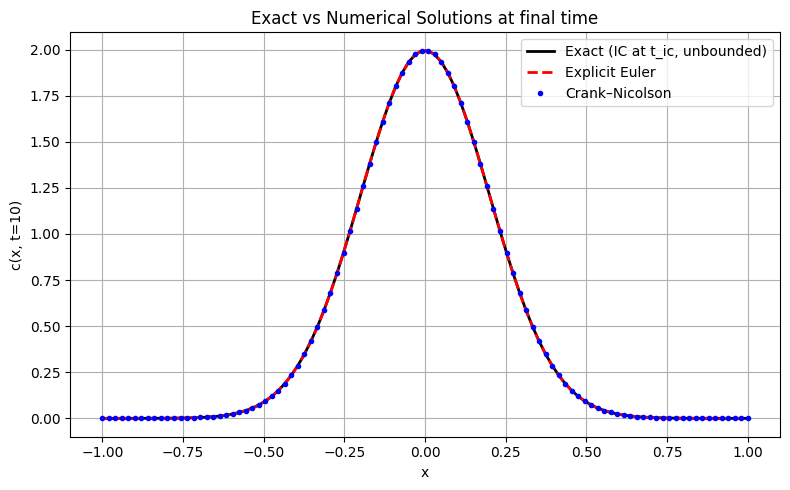

Rel L2 vs exact:  EE=4.652e-04   CN=5.451e-04


In [34]:
def EE(x, t, kappa):
    """
    Explicit Euler for the 1-D diffusion equation with homogeneous Neumann BCs.
    c^{n+1} = c^n + dt * kappa * M c^n
    """
    import time
    dt = t[1] - t[0]
    M  = construct_M_with_BC(x)
    Nx, Nt = len(x), len(t)
    c = np.zeros((Nx, Nt))

    # set initial condition (t_ic=10)
    t_ic = 10.0
    c[:, 0] = set_ics(x, kappa, t_ic)

    start = time.time()
    for k in range(1, Nt):
        c[:, k] = c[:, k-1] + dt * kappa * (M @ c[:, k-1])
        # enforce Neumann BCs each step (∂x c = 0 at ends)
        c[0, k]  = c[1, k]
        c[-1, k] = c[-2, k]
    end = time.time()
    print(f"Explicit Euler took {end - start:.2f} s")
    return c


# 2) Exact-vs-Numerical at final time
c_EE = EE(x, t, kappa)
c_CN = CN(x, t, kappa)

# final time and slices
t_final_idx = -1
t_val = t[t_final_idx]
c_euler_final = c_EE[:, t_final_idx]
c_cn_final    = c_CN[:, t_final_idx]

# exact solution
t_ic = 10.0
teff = t_ic + t_val
c_exact = (1.0 / np.sqrt(4.0 * np.pi * kappa * teff)) * np.exp(-x**2 / (4.0 * kappa * teff))

# plot results
plt.figure(figsize=(8, 5))
plt.plot(x, c_exact, color='k', lw=2, label='Exact (IC at t_ic, unbounded)')
plt.plot(x, c_euler_final, color='red', lw=2, linestyle='--', label='Explicit Euler')
plt.plot(x, c_cn_final, 'b.', lw=2, label='Crank–Nicolson')
plt.xlabel('x')
plt.ylabel(f'c(x, t={t_val:g})')
plt.title('Exact vs Numerical Solutions at final time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# accuracy number
def relL2(a, b):
    return np.linalg.norm(a - b) / np.linalg.norm(b)
print(f"Rel L2 vs exact:  EE={relL2(c_euler_final, c_exact):.3e}   CN={relL2(c_cn_final, c_exact):.3e}")

The difference between the exact solution and the numerical approximation can be quantified by various measures of error. The *local error* is the difference between the exact solution and the numerical approximation after one timestep. The *global error* is the difference between the solutions after a fixed amount of time (which includes the accumulation of multiple steps of local error). A method is first order accurate if the global error is linearly proportional to the timestep. A method is second order accurate if the global error varies quadratically with the timestep. Below, calculate and plot the global error for the Explicit Euler and Crank-Nicolson methods and use your results to infer the order of accuracy of each scheme.

PLOT GLOBAL ERROR FOR EACH SCHEME (1-2 figures) AND DISCUSS ORDER OF ACCURACY (2-3 sentences)

Observed order — EE: ~1.15  |  CN: ~2.01


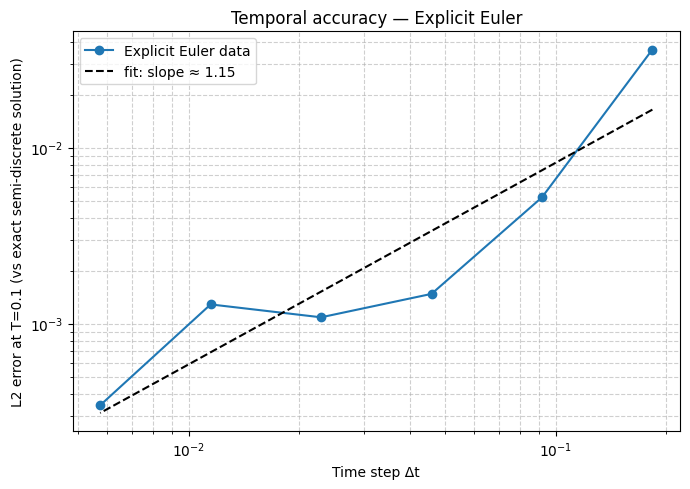

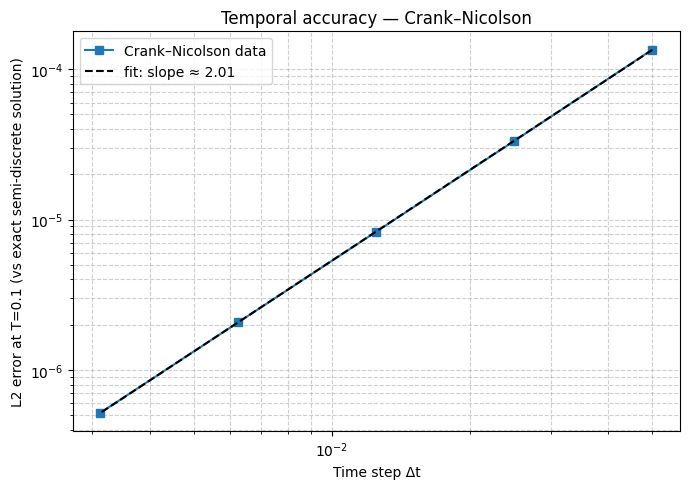

In [39]:
import numpy as np, matplotlib.pyplot as plt
import scipy.sparse as sp, scipy.sparse.linalg as spla
from scipy.sparse.linalg import expm_multiply

# Parameters
kappa = 0.001
Nx    = len(x)
M     = construct_M_with_BC(x)
I     = sp.eye(Nx, format="csr")
Tfinal = 0.1

# BC-compatible initial condition (Neumann eigenmode)
m = 1
u0 = np.cos(m*np.pi*(x+1.0)/2.0)

# Exact-in-time reference for the semi-discrete system
u_ref = expm_multiply(kappa*M, u0, start=0.0, stop=Tfinal, num=2)[-1]

# Time-stepping schemes
def solve_EE(u0, dt, T):
    n = int(np.round(T/dt))
    A = (I + dt*kappa*M).tocsr()
    u = u0.copy()
    for _ in range(n):
        u = A @ u
    return u

def solve_CN(u0, dt, T):
    n = int(np.round(T/dt))
    A_L = (I - 0.5*dt*kappa*M).tocsc()
    A_R = (I + 0.5*dt*kappa*M).tocsr()
    solve = spla.factorized(A_L)
    u = u0.copy()
    for _ in range(n):
        u = solve(A_R @ u)
    return u

def l2(a): return np.linalg.norm(a)/np.sqrt(Nx)
def fit_order(dts, errs):
    p, logC = np.polyfit(np.log(dts), np.log(errs), 1)
    return p, np.exp(logC)

# Δt ranges
dx = x[1]-x[0]
r_max = 0.45
dt0 = r_max*dx*dx/kappa
dts_EE = dt0 * (0.5**np.arange(0,6))
dts_CN = np.array([0.05, 0.025, 0.0125, 0.00625, 0.003125])

# Compute errors
errs_EE = [l2(solve_EE(u0, dt, Tfinal) - u_ref) for dt in dts_EE]
errs_CN = [l2(solve_CN(u0, dt, Tfinal) - u_ref) for dt in dts_CN]

# Fit slopes
p_EE, C_EE = fit_order(dts_EE, errs_EE)
p_CN, C_CN = fit_order(dts_CN, errs_CN)

print(f"Observed order — EE: ~{p_EE:.2f}  |  CN: ~{p_CN:.2f}")

# Plot Explicit Euler
plt.figure(figsize=(7,5))
plt.loglog(dts_EE, errs_EE, 'o-', label=f'Explicit Euler data')
plt.loglog(dts_EE, C_EE*dts_EE**p_EE, 'k--', label=f'fit: slope ≈ {p_EE:.2f}')
plt.xlabel("Time step Δt")
plt.ylabel("L2 error at T=0.1 (vs exact semi-discrete solution)")
plt.title("Temporal accuracy — Explicit Euler")
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Plot Crank–Nicolson
plt.figure(figsize=(7,5))
plt.loglog(dts_CN, errs_CN, 's-', label=f'Crank–Nicolson data')
plt.loglog(dts_CN, C_CN*dts_CN**p_CN, 'k--', label=f'fit: slope ≈ {p_CN:.2f}')
plt.xlabel("Time step Δt")
plt.ylabel("L2 error at T=0.1 (vs exact semi-discrete solution)")
plt.title("Temporal accuracy — Crank–Nicolson")
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.tight_layout()
plt.show()

**2.2 Discussion: Order of Accuracy**

The global error plots show that as the timestep decreases the error in the numerical solutions also decreases. The crank-nicolson error decreases more quickly with decreaseing timestep then the explicit euler as shown by the slopes of the plots. this makes Crank nicolson the more efficient method for achieving higher accuracy.

The global error decreases approximately linearly with Δt for the Explicit Euler method, indicating first-order accuracy in time. In contrast, the error decreases quadratically with Δt for the Crank–Nicolson method, demonstrating second-order temporal accuracy. This difference arises because Euler uses only present-time information, while Crank–Nicolson implicitly averages between the present and future time levels, providing a more accurate approximation of the time derivative.


The observed slopes for global error can also be influenced by the fixed spatial resolution of the grid. If temporal error becomes smaller than the spatial error, the total error is dominated by this spatial component, causing the error plot to flatten out and show slopes lower than the true temporal orders of accuracy. To see slopes closer to the theoretical values, a finer spatial grid is often needed to reduce the spatial error.

Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

Explicit Euler took 0.18 s


/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


Crank-Nicolson method took 0.53 seconds
Explicit Euler took 0.00 s
Crank-Nicolson method took 0.03 seconds
Explicit Euler took 0.00 s
Crank-Nicolson method took 0.03 seconds
Explicit Euler took 0.00 s
Crank-Nicolson method took 0.03 seconds
Explicit Euler took 0.00 s
Crank-Nicolson method took 0.04 seconds
Explicit Euler took 0.01 s
Crank-Nicolson method took 0.05 seconds
Explicit Euler took 0.02 s
Crank-Nicolson method took 0.07 seconds
Explicit Euler took 0.03 s
Crank-Nicolson method took 0.14 seconds
Explicit Euler took 0.06 s
Crank-Nicolson method took 0.22 seconds


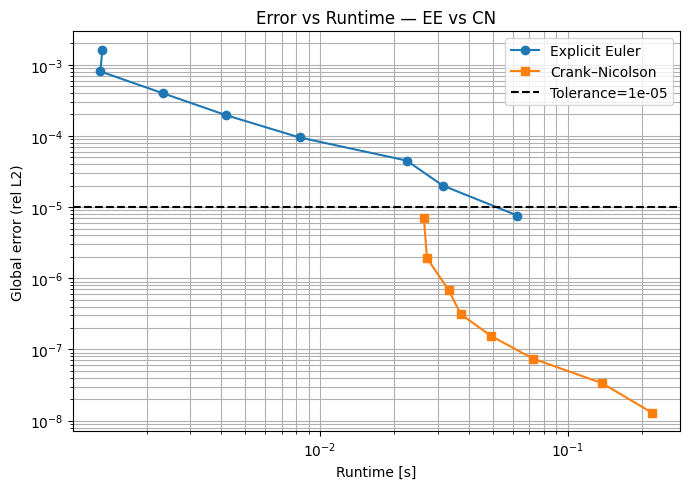

EE min time to reach tol=1e-05: 0.0627 s
CN min time to reach tol=1e-05: 0.0263 s


In [48]:
import numpy as np
import time
import matplotlib.pyplot as plt

# --- parameters ---
tol = 1E-5                  # error tolerance (adjust if needed)
Tfinal = 10.0
CN_func = CN_with_BC if 'CN_with_BC' in globals() else CN

# --- reference solution ---
# use a very fine time step to define "true" solution
Nt_ref = 2**14  # very fine
t_ref = np.linspace(0, Tfinal, Nt_ref)
c_ref_EE = EE(x, t_ref, kappa)[:, -1]
c_ref_CN = CN_func(x, t_ref, kappa)[:, -1]

def relL2(a,b):
    return np.linalg.norm(a - b)/np.linalg.norm(b)

def run_and_measure(method, Nt, c_ref):
    t_arr = np.linspace(0, Tfinal, Nt)
    start = time.time()
    c_final = method(x, t_arr, kappa)[:, -1]
    runtime = time.time() - start
    err = relL2(c_final, c_ref)
    return runtime, err

# --- test a range of time step counts ---
Nt_list = [50, 100, 200, 400, 800, 1600, 3200, 6400]

EE_times, EE_errs = [], []
CN_times, CN_errs = [], []

for Nt in Nt_list:
    tEE, eEE = run_and_measure(EE, Nt, c_ref_EE)
    tCN, eCN = run_and_measure(CN_func, Nt, c_ref_CN)
    EE_times.append(tEE); EE_errs.append(eEE)
    CN_times.append(tCN); CN_errs.append(eCN)

EE_times = np.array(EE_times)
EE_errs  = np.array(EE_errs)
CN_times = np.array(CN_times)
CN_errs  = np.array(CN_errs)

# --- find minimal runtime to reach target tolerance ---
def min_runtime(times, errs, tol):
    valid = errs <= tol
    return np.min(times[valid]) if np.any(valid) else np.nan

EE_min_time = min_runtime(EE_times, EE_errs, tol)
CN_min_time = min_runtime(CN_times, CN_errs, tol)

# --- plots: error vs runtime ---
plt.figure(figsize=(7,5))
plt.loglog(EE_times, EE_errs, 'o-', label='Explicit Euler')
plt.loglog(CN_times, CN_errs, 's-', label='Crank–Nicolson')
plt.axhline(tol, color='k', linestyle='--', label=f'Tolerance={tol}')
plt.xlabel('Runtime [s]')
plt.ylabel('Global error (rel L2)')
plt.title('Error vs Runtime — EE vs CN')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

print(f"EE min time to reach tol={tol}: {EE_min_time:.4f} s")
print(f"CN min time to reach tol={tol}: {CN_min_time:.4f} s")


**2.2 Discussion: Error**


At an error tolerance of 1×10⁻⁵, the Error vs Runtime plot demonstrates that the Crank–Nicolson method is more computationally efficient than the Explicit Euler scheme. While both methods show decreasing error with increasing runtime, the Euler curve (blue) exhibits a gentler slope consistent with first-order temporal accuracy, requiring significantly more time steps—and therefore longer runtime—to achieve the same precision. In contrast, the Crank–Nicolson curve (orange) declines more steeply, reflecting its second-order accuracy, and reaches the target error in roughly 0.026 s compared to 0.063 s for Euler. This confirms that although Crank–Nicolson incurs a higher per-step cost due to matrix inversion, its superior convergence rate makes it substantially more efficient for higher-accuracy simulations.

When the error tolerance is loosened (for example, from 10⁻⁵ to 10⁻⁴ or 10⁻³), the Explicit Euler method becomes more efficient. At lower accuracy targets, its simple update rule and cheap computation per time step outweigh the benefits of Crank–Nicolson’s higher-order accuracy. Since the explicit scheme is first-order, it already satisfies a moderate tolerance with relatively few steps, and the additional overhead of solving linear systems in Crank–Nicolson is unnecessary.

When the error tolerance is tightened (e.g., from 10⁻⁵ to 10⁻⁶ or lower), the situation reverses. The Crank–Nicolson method becomes increasingly more efficient because its second-order convergence allows the error to decrease much faster with time-step refinement. The Explicit Euler scheme, in contrast, must take exponentially more steps—and therefore much longer runtimes—to reach the same accuracy, and may even become unstable if the required Δt falls below its stability limit.

In summary, Explicit Euler is more efficient for low-accuracy, short simulations, whereas Crank–Nicolson dominates for high-accuracy or long-duration problems where second-order convergence and unconditional stability provide a clear computational advantage.

### 2.3 Boundary conditions for Crank-Nicolson scheme
<a id='section2pt3'></a>

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This should ensure that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. Plot your results below and verify that the boundary conditions are satisfied.  How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?

Crank–Nicolson with BC took 0.09 seconds


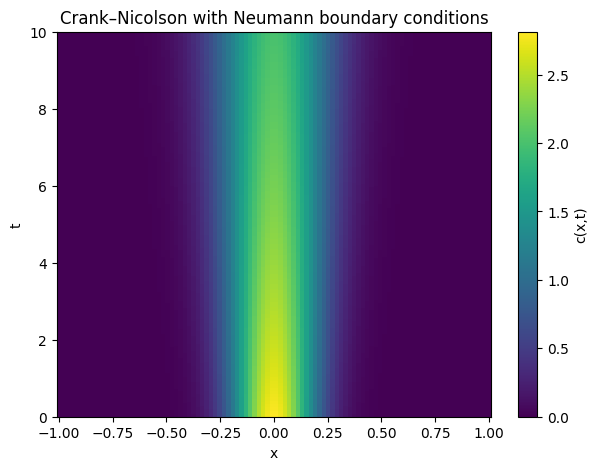

In [49]:
# Modified coefficient matrix for Neumann boundary conditions
def construct_M_with_BC(x):
    dx = x[1] - x[0]
    Nx = len(x)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Neumann BC: zero gradient (no flux at boundaries)
    # Left boundary
    M[0, 0] = -2 / dx**2
    M[0, 1] =  2 / dx**2

    # Right boundary
    M[-1, -1] = -2 / dx**2
    M[-1, -2] =  2 / dx**2

    return sp.csr_matrix(M)


# Updated Crank–Nicolson function using new matrix
def CN_with_BC(x, t, kappa):
    start_time = time.time()
    dt = t[1] - t[0]

    M = construct_M_with_BC(x)  # use modified matrix
    Nx = len(x); Nt = len(t)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M
    A_inv = spla.inv(A)

    c = np.zeros((Nx, Nt))
    c[:, 0] = set_ics(x, kappa, 10)

    for k in range(1, Nt):
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))

    end_time = time.time()
    print(f"Crank–Nicolson with BC took {end_time - start_time:.2f} seconds")
    return c


# Run simulation and plot
c_CN_BC = CN_with_BC(x, t, kappa)

plt.figure(figsize=(7, 5))
plt.pcolormesh(x, t, c_CN_BC.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank–Nicolson with Neumann boundary conditions')
plt.colorbar(label='c(x,t)')
plt.show()

"**Discussion of Dirichlet and Neumann Boundary Conditions**

When solving the diffusion equation using finite difference methods, boundary conditions are crucial for specifying the behavior of the solution at the edges of the domain. For implicit or semi-implicit schemes like Crank-Nicolson, boundary conditions are typically incorporated directly into the linear system that is solved at each timestep.

**Neumann Boundary Conditions (Fixed Gradient or No Flux):** These conditions specify the value of the derivative of the solution at the boundary (e.g., $\partial_x c = 0$ for no flux). As demonstrated in the code above, homogeneous Neumann boundary conditions can be implemented by modifying the rows of the coefficient matrix ($M$) corresponding to the boundary points. This involves adjusting the finite difference stencil at the edges to enforce the specified gradient using virtual points or by directly incorporating the boundary condition into the discrete derivative approximation. By embedding these modifications in the matrix, the boundary conditions are implicitly satisfied by the solution of the linear system at each timestep.

**Dirichlet Boundary Conditions (Fixed Value):** These conditions specify the value of the solution itself at the boundary (e.g., $c(x_0, t) = c_{boundary}$). For an implicit scheme, Dirichlet conditions are handled differently. Instead of modifying the matrix rows to approximate the derivative, you fix the known boundary values and adjust the linear system accordingly. This is usually done by:
1.  Removing the equations corresponding to the boundary points from the system for the unknown values at the interior points.
2.  Moving the terms in the equations for the interior points that involve the known boundary values to the right-hand side vector of the linear system.

For example, if $c_0^{n+1}$ is a known Dirichlet value, the first equation in the system for the interior points would be modified to account for the term involving $c_0^{n+1}$ and include it on the right-hand side. The first unknown would then be $c_1^{n+1}$.

By correctly incorporating either Neumann or Dirichlet conditions into the matrix and right-hand side vector of the linear system solved at each time step, the numerical solution will satisfy the desired behavior at the domain boundaries throughout the simulation."